In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from numpy.linalg import eig
import os
from PointDistributionModel import PointDistributionModel 
from scipy.linalg import svd
import seaborn as sns

sns.set_context('poster')

In [2]:
df = pd.DataFrame([], columns=['Vessel','Landmark','X','Y'])
fileCount = 0
for file in os.listdir('Data'):
    data = np.loadtxt('Data/'+file, delimiter=',', skiprows=1)
    data1 = data[:9, :] # First vessel
    data2 = data[[0,9,10,11,12,13,14,15,16],:] # Second vessel
    
    tmp = pd.DataFrame(data, columns=['Landmark', 'X', 'Y'])
    tmp['Vessel'] = file

    # tmp = pd.DataFrame(data1, columns=['Landmark', 'X', 'Y'])
    # tmp.Landmark = np.arange(tmp.shape[0])
    # tmp['Vessel'] = fileCount
    # df = pd.concat((df,tmp))
    # fileCount +=1
    # tmp = pd.DataFrame(data2, columns=['Landmark', 'X', 'Y'])
    # tmp.Landmark = np.arange(tmp.shape[0])
    # tmp['Vessel'] = fileCount
    # fileCount +=1
    df = pd.concat((df,tmp))

df = df.loc[(df.Landmark != 9) & (df.Landmark != 18)]

shapeList = []
for Vessel in np.unique(df.Vessel.values):
    shape = df.loc[df.Vessel==Vessel, ['X','Y']].to_numpy()
    shapeList.append(shape)


df.to_csv('Landmark.csv')

In [3]:
PDM = PointDistributionModel(shapeList)
PDM.fit()

Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=2.7975181299443865.
	Distance between mean shape and reference shape dist=0.9503140472600102.
	Distance between mean shape and reference shape dist=0.9503140472600102.
	Distance between mean shape and reference shape dist=0.9503140472600101.
	Distance between mean shape and reference shape dist=0.9503140472600102.


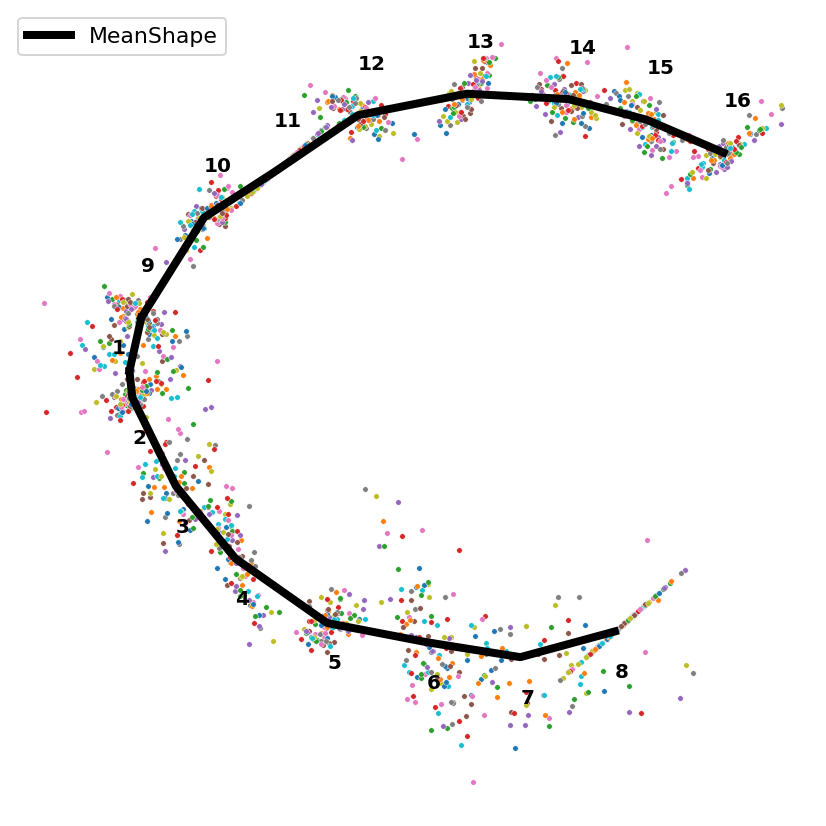

In [4]:
generatedShapes = PDM.generate(100, stdFactor=8)

fig, ax = plt.subplots(figsize=(12,12))
xmean, ymean = PDM._meanShape[:16:2], PDM._meanShape[1:16:2]
sns.lineplot(x=xmean, y=ymean, label='MeanShape', linewidth=8, color='black', ax=ax)
ax.annotate(1, (-0.2,0), weight='bold', size=20)
for i in range(1,xmean.size):
    ax.annotate(i+1, (xmean[i],ymean[i]-0.04), weight='bold', size=20)   

xmean, ymean = PDM._meanShape[16::2], PDM._meanShape[17::2]
sns.lineplot(x=xmean, y=ymean, linewidth=8, color='black', ax=ax)
sns.lineplot(x=[PDM._meanShape[0], PDM._meanShape[16]], y=[PDM._meanShape[1], PDM._meanShape[17]], linewidth=8, color='black', ax=ax)

for j in range(xmean.size):
    ax.annotate(i+j+2, (xmean[j],ymean[j]+0.04), weight='bold', size=20)   

for shape in generatedShapes:
    sns.scatterplot(x = shape[:,0], y = shape[:,1], ax=ax, s=30)
sns.despine(fig=fig, left=True, bottom=True)
plt.axis('off')
plt.legend()
fig.tight_layout()
plt.savefig('PDM.jpg', dpi=800)

In [5]:
shape = PDM.generate(1, stdFactor=8)[0]
PDM.ToCCO(shape, 'test.cco', nLandmarks=(7,8))


Running generalized procruste analysis on the data.
	Distance between mean shape and reference shape dist=0.9503140472600102.
	Distance between mean shape and reference shape dist=0.9503140472600102.
	Distance between mean shape and reference shape dist=0.9503140472600101.
	Distance between mean shape and reference shape dist=0.9503140472600102.
	Distance between mean shape and reference shape dist=0.9503140472600103.
(32, 12)
Real part 5.2209059596982526 vs imaginary part 2.1776457379443688


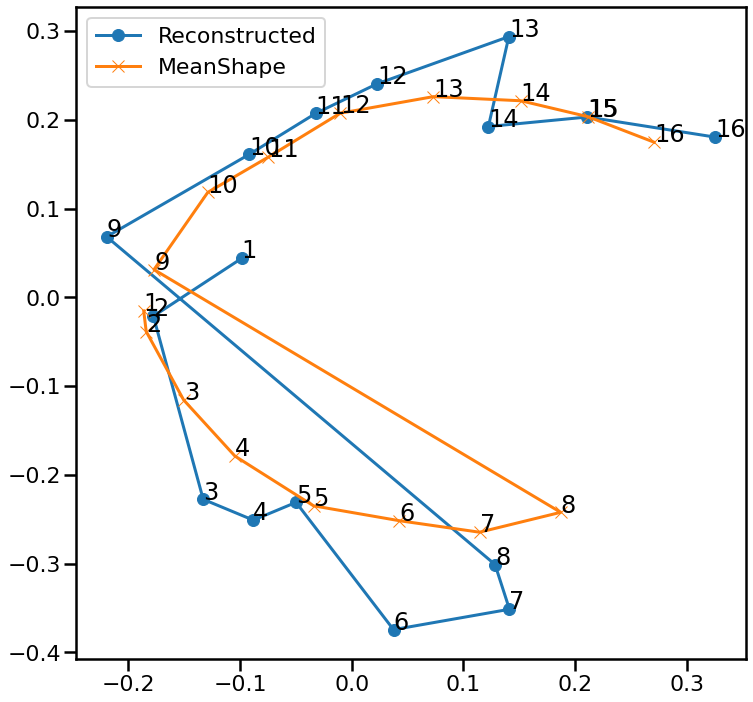

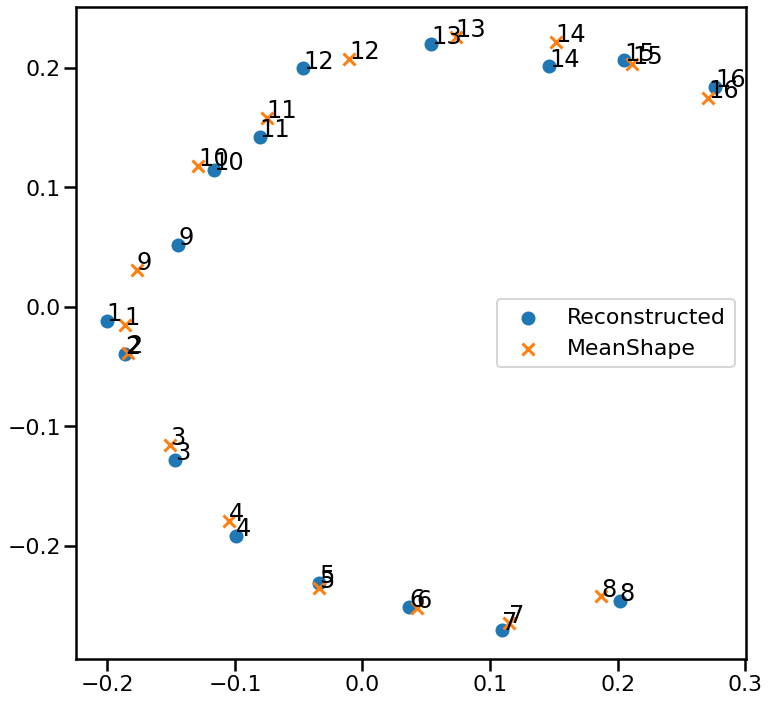

In [6]:

newShapes, meanShape = PointDistributionModel.GeneralizedProcrustesAnalysis(shapeList, maxIter=5)
df = pd.DataFrame([], columns=['Shape', 'Landmark', 'X', 'Y'])
for i, shape in enumerate(newShapes):
    tmp = pd.DataFrame(np.zeros((shape.shape[0],4)), columns=['Shape', 'Landmark', 'X', 'Y'])
    tmp['X'] = shape[:,0]
    tmp['Y'] = shape[:,1]
    tmp.Shape = i+1
    tmp.Landmark = np.arange(1, shape.shape[0]+1)
    df = pd.concat((df, tmp))
df = df.set_index(['Shape', 'Landmark'])
df.to_csv('Landmarks_Aligned.csv')
df
df = pd.read_csv('Landmarks_Aligned.csv', index_col=(0,1))
shapes = df.index.get_level_values('Shape').drop_duplicates()
n = shapes.size
data = np.zeros((2*df.index.get_level_values('Landmark').drop_duplicates().size, n))
for i, shape in enumerate(shapes):
    landmarks = df.loc[shape].values[:,:].ravel().T
    data[:,i] = landmarks   
print(data.shape)
pca = PCA(whiten=True)
pca.fit(data.T)
cov = pca.get_covariance()
eigva, eigve = eig(cov)
P = np.real(eigve).T
print(f'Real part {np.linalg.norm(P)} vs imaginary part {np.linalg.norm(np.imag(eigve))}')
stds = np.sqrt(np.abs(eigva))
meanShape = np.zeros((data.shape[0],))
m,N = data.shape
for i in range(N):
    meanShape += data[:,i]
meanShape /= N
meanShape = meanShape.reshape((meanShape.shape[0],1))
b = np.random.normal(0.0, stds*10)
xn = meanShape[:,0] + P.dot(b)
x,y = xn[::2], xn[1::2]
fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.plot(x,y, label='Reconstructed', marker='o')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.plot(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()
W = (data-meanShape.dot(np.ones((1,N))))/(np.sqrt(N-1))
U,s,V = svd(W.T, full_matrices=True)
p = V.shape[0]
b = np.random.normal(0.0, scale=3*stds)
xn = meanShape[:,0] + V.dot(b)
x,y = xn[::2], xn[1::2]

fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.scatter(x,y, label='Reconstructed')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.scatter(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()